In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
import warnings

warnings.filterwarnings("ignore")

In [ ]:
pd.__version__

In [2]:
train = pd.read_csv('./funda_train.csv')
submission = pd.read_csv('./submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


store_id : 상점의 고유 아이디<br/>
card_id : 사용한 카드의 고유 아이디<br/>
card_company : 비식별화된 카드 회사<br/>
transacted_date : 거래 날짜<br/>
transacted_time : 거래 시간<br/>
installment_term : 할부 개월 수<br/>
region : 상점의 지역<br/>
type_of_business : 상점의 업종<br/>
amount : 매출액 (원 단위 아님)

# 데이터 전처리

## 노이즈 제거

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

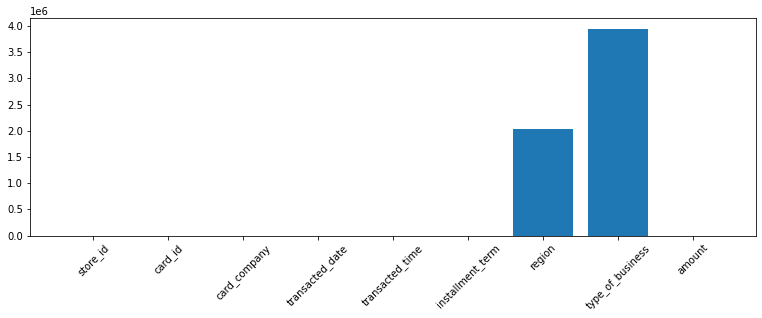

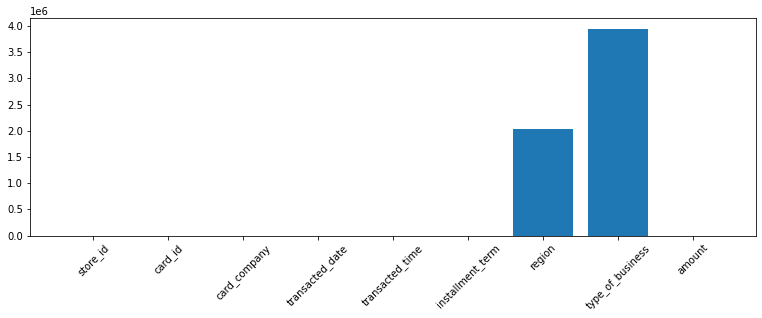

In [4]:
plt.figure(figsize=(13,4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

# y축을 null개수로 둬서 결측값 그래프로 확인

In [5]:
train = train.drop(['region', 'type_of_business'], axis=1)
train.head()

# region이랑 type_of_business 변수에만 결측값이 존재하는데, 이 변수는 object형이므로 값을 대체할 수가 없음! -> 열 삭제

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


<AxesSubplot:xlabel='amount'>

<AxesSubplot:xlabel='amount'>

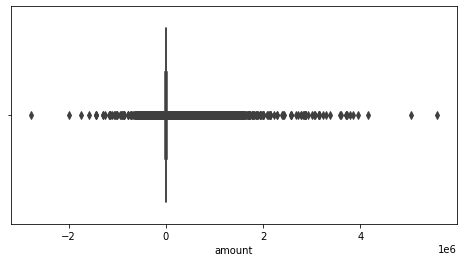

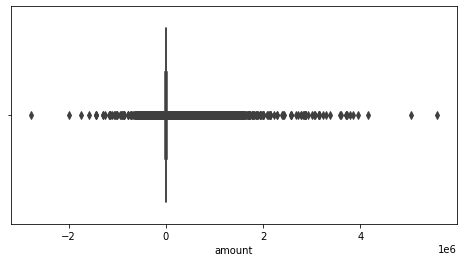

In [6]:
plt.figure(figsize=(8,4))
sns.boxplot(train['amount'])

# amount값 분포 확인 -> 판매량에 음수값이 존재하는 것을 확인할 수 있음

In [7]:
# 거래일과 거래시간을 합친 변수 생성
train['datetime'] = pd.to_datetime(train.transacted_date + " " + train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [8]:
# amount < 0 제거 -> 즉, 환불 거래 제거하는 함수
def remove_refund(df):
    refund = df[df['amount']<0]
    non_refund = df[df['amount']>0]
    removed_data = pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data = non_refund[non_refund['store_id']==i]  # 같은 상점 아이디 기준
        divided_data2 = refund[refund['store_id']==i]
        
        for neg in divided_data2.to_records()[:]:
            refund_store = neg['store_id']
            refund_id = neg['card_id']
            refund_datetime = neg['datetime']
            refund_amount = abs(neg['amount'])
            
            refund_pay_list = divided_data[divided_data['datetime']<=refund_datetime]  # 환불 날짜보다 이전 날짜
            refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]   # 카드 아이디는 동일해야함
            refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount] # 환불금액과 동일한 금액
            
            if len(refund_pay_list) != 0:
                refund_datatime = max(refund_pay_list['datetime'])
                noise_list = divided_data[divided_data['datetime']==refund_datetime]
                noise_list = noise_list[noise_list['card_id']==refund_id]
                noise_list = noise_list[noise_list['amount']==refund_amount]
                divided_data = divided_data.drop(index=noise_list.index)
                
        removed_data = pd.concat([removed_data, divided_data], axis=0)  # 상점 별로 환불 거래 제거한 데이터들을 removed_data와 concat
        
    return removed_data

In [9]:
positive_data = remove_refund(train)

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [11:07<00:00,  2.95it/s]



<AxesSubplot:xlabel='amount'>

<AxesSubplot:xlabel='amount'>

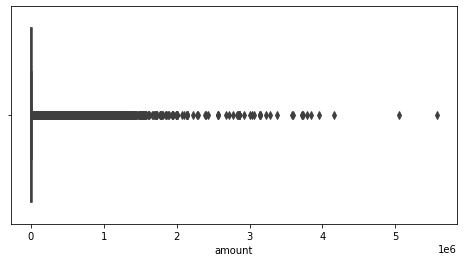

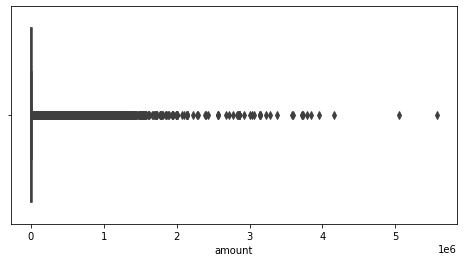

In [10]:
plt.figure(figsize=(8,4))
sns.boxplot(positive_data['amount'])

# amount 음수인 값 제거한 것 확인!

## 다운 샘플링

In [11]:
def month_resampling(df):
    new_data = pd.DataFrame()
    df['year_month'] = df['transacted_date'].str.slice(stop=7) # year, month까지 자르기
    year_month = df['year_month'].drop_duplicates()
    
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False, inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        store = downsampling_data[downsampling_data['store_id']==i]
        start_time = min(store['year_month'])  # 각 상점의 처음 매출이 발생한 월 구하기
        store = store.merge(year_month, how='outer') 
        store = store.sort_values(by=['year_month'], axis=0, ascending=True) # 데이터 시간순으로 정렬
        
        store['amount'] = store['amount'].fillna(2)
        store['store_id'] = store['store_id'].fillna(i)
        store = store[store['year_month']>=start_time] # 처음 매출이 발생한 월 이후로 뽑음
         
        new_data = pd.concat([new_data, store], axis=0)
        
    return new_data

In [12]:
resampling_data = month_resampling(positive_data)
resampling_data

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:11<00:00, 167.27it/s]


,store_id,year_month,amount
0,0.0,2016-06,7.470000e+05
1,0.0,2016-07,1.005000e+06
2,0.0,2016-08,8.697143e+05
3,0.0,2016-09,8.978571e+05
4,0.0,2016-10,8.374286e+05
...,...,...,...
17,2136.0,2018-10,2.012214e+06
18,2136.0,2018-11,2.149214e+06
19,2136.0,2018-12,2.431429e+06
20,2136.0,2019-01,1.867786e+06


,store_id,year_month,amount
0,0.0,2016-06,7.470000e+05
1,0.0,2016-07,1.005000e+06
2,0.0,2016-08,8.697143e+05
3,0.0,2016-09,8.978571e+05
4,0.0,2016-10,8.374286e+05
...,...,...,...
17,2136.0,2018-10,2.012214e+06
18,2136.0,2018-11,2.149214e+06
19,2136.0,2018-12,2.431429e+06
20,2136.0,2019-01,1.867786e+06


In [13]:
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data

# store_id int형으로 변환

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.374286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.149214e+06
19,2136,2018-12,2.431429e+06
20,2136,2019-01,1.867786e+06


,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.374286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.149214e+06
19,2136,2018-12,2.431429e+06
20,2136,2019-01,1.867786e+06


## 날짜 지정 범위 생성과 시리즈 객체 변환

In [14]:
# 데이터프레임을 시리즈로 변환하는 함수 -> 시계열 데이터 분석을 위해서는 데이터프레임을 시리즈 객체로 변환해야 함
def time_series(df, i):
    store = df[df['store_id']==i]
    index = pd.date_range(min(store['year_month']), '2019-03', freq='BM')
    ts = pd.Series(store['amount'].values, index=index)
    
    return ts

In [15]:
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.374286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431614e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.884286e+05
2018-06-29    7.072857e+05
2018-07-31    7.637143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.374286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431614e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.884286e+05
2018-06-29    7.072857e+05
2018-07-31    7.637143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

Text(0, 0.5, 'amount')

Text(0, 0.5, 'amount')

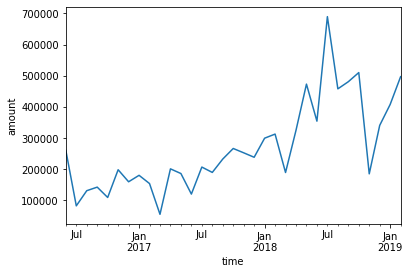

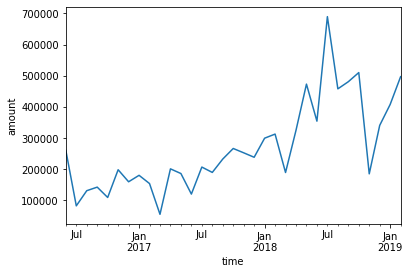

In [16]:
store_2 = time_series(resampling_data, 2)
store_2.plot()
plt.xlabel('time')
plt.ylabel('amount')

# 탐색적 데이터 분석

## 상점별 매출 특성

In [17]:
#for i in train['store_id'].unique():
    #store = time_series(resampling_data, i)
    #plt.figure(figsize=(13,5))
    #plt.xlabel(i)
    #store.plot()

In [18]:
store_257 = time_series(resampling_data, 257)
store_257

2016-06-30    5.316143e+05
2016-07-29    1.740566e+06
2016-08-31    1.555643e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    2.187429e+05
2017-06-30    5.490571e+05
2017-07-31    7.657857e+05
2017-08-31    8.060557e+05
2017-09-29    6.977143e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    1.428571e+03
2018-05-31    2.495286e+05
2018-06-29    4.979429e+05
2018-07-31    1.086437e+06
2018-08-31    1.697734e+06
2018-09-28    3.226714e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

2016-06-30    5.316143e+05
2016-07-29    1.740566e+06
2016-08-31    1.555643e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    2.187429e+05
2017-06-30    5.490571e+05
2017-07-31    7.657857e+05
2017-08-31    8.060557e+05
2017-09-29    6.977143e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    1.428571e+03
2018-05-31    2.495286e+05
2018-06-29    4.979429e+05
2018-07-31    1.086437e+06
2018-08-31    1.697734e+06
2018-09-28    3.226714e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

<AxesSubplot:>

<AxesSubplot:>

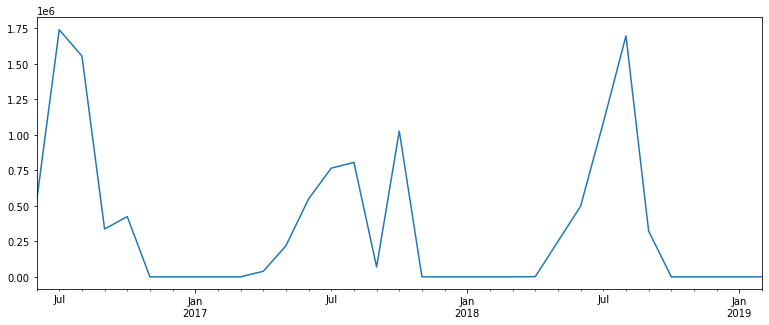

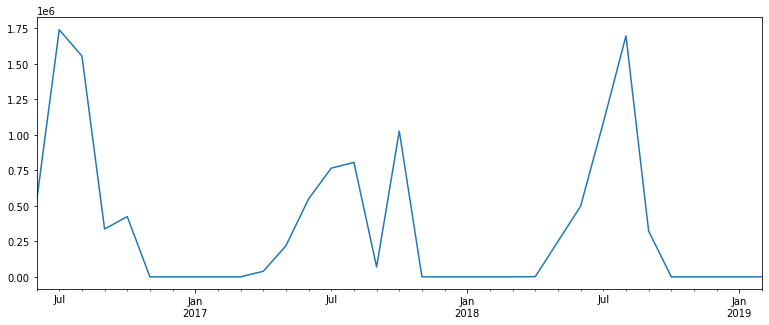

In [19]:
# 계절성이 있는 상점
plt.figure(figsize=(13,5))
store_257.plot()

<AxesSubplot:>

<AxesSubplot:>

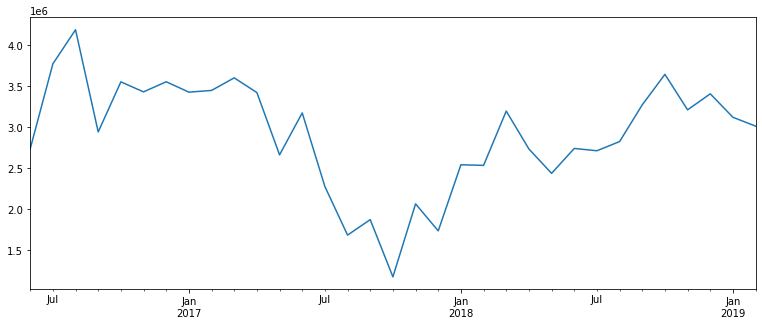

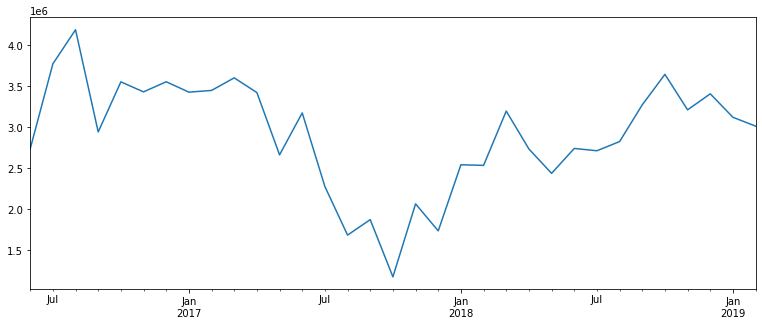

In [20]:
# 추세가 있는 상점
store_335 = time_series(resampling_data, 335)
plt.figure(figsize=(13,5))
store_335.plot()

<AxesSubplot:>

<AxesSubplot:>

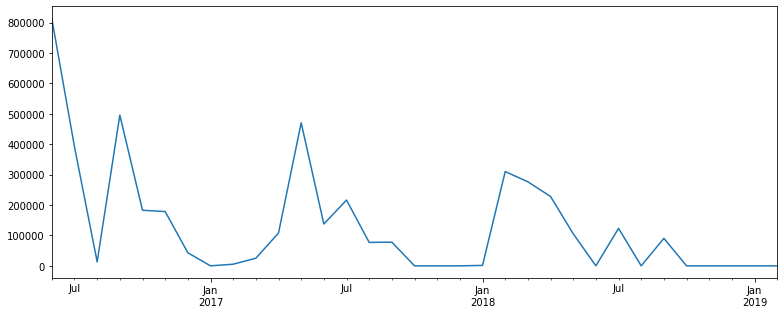

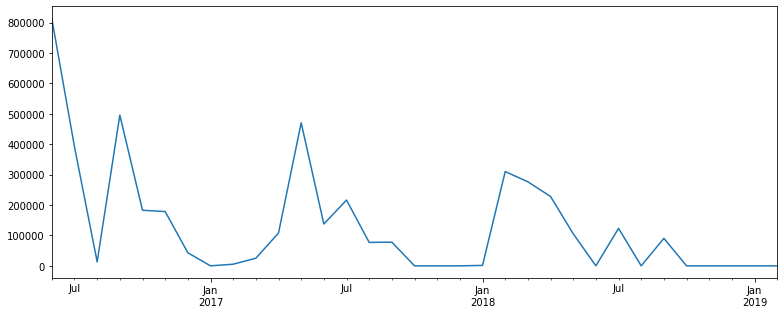

In [21]:
# 휴업 중인 상점
store_111 = time_series(resampling_data, 111)
plt.figure(figsize=(13,5))
store_111.plot()

## 시계열 데이터의 정상성

In [22]:
from pmdarima.arima import ADFTest

store_0 = time_series(resampling_data,0)
p_val, should_diff = ADFTest().should_diff(store_0)
print('p_val : %f, should_diff : %s' %(p_val, should_diff))

p_val : 0.023217, should_diff : False
p_val : 0.023217, should_diff : False


In [23]:
store_257 = time_series(resampling_data,257)
p_val, should_diff = ADFTest().should_diff(store_257)
print('p_val : %f, should_diff : %s' %(p_val, should_diff))

p_val : 0.096889, should_diff : True
p_val : 0.096889, should_diff : True


In [24]:
# p-value 확인 함수
def adf_test(y):
    return ADFTest().should_diff(y)[0]

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:08<00:00, 244.52it/s]


<AxesSubplot:>

<AxesSubplot:>

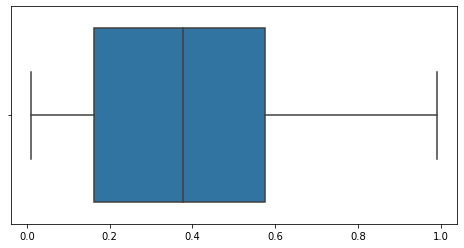

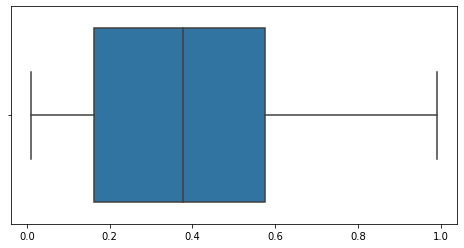

In [25]:
adf_p = []
count = 0
skipped = []

for i in tqdm(resampling_data['store_id'].unique()):
    ts = time_series(resampling_data, i)
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    except:
        skipped.append(i)
        
plt.figure(figsize=(8,4))
sns.boxplot(adf_p)

# 모델 구축과 검증

## 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [26]:
# 파이썬에서 R패키지를 설치하는 과정
from rpy2.robjects.packages import importr

utils = importr('utils')
utils.install_packages('forecast')
utils.install_packages('forecastHybrid')

rpy2.rinterface.NULL

rpy2.rinterface.NULL

In [27]:
# r함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects

# 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri

pandas2ri.activate()

# forecast 패키지를 이용해 상점 아이디가 0번인 상점에 대해 ARIMA 모델로 예측값 생성
auto_arima = """
    function(ts){
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

In [28]:
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')
c = robjects.r('c')

In [29]:
store_0 = resampling_data[resampling_data['store_id']==0]

# 영업 시작 년도
start_year = int(min(store_0['year_month'])[:4]) 

# 영업 시작 월
start_month = int(min(store_0['year_month'])[5:])

# r의 ts함수로 r의 time series 자료형으로 변환
train = ts(store_0['amount'], start = c(start_year, start_month), frequency=12)

In [30]:
forecast = auto_arima(train)
np.sum(pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산

2054149.4630046578

2054149.4630046578

## 시계열 모델 선택과 검증

### 1) ARIMA

In [31]:
# r함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects

# 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri

pandas2ri.activate()

# forecast 패키지를 이용해 상점 아이디가 0번인 상점에 대해 ARIMA 모델로 예측값 생성
auto_arima = """
    function(ts){
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store_0 = resampling_data[resampling_data['store_id']==i]

    # 영업 시작 년도
    start_year = int(min(store_0['year_month'])[:4]) 

    # 영업 시작 월
    start_month = int(min(store_0['year_month'])[5:])

    # r의 ts함수로 r의 time series 자료형으로 변환
    train = ts(store_0['amount'], start = c(start_year, start_month), frequency=12)
    
    forecast = auto_arima(train)
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [01:52<00:00, 17.50it/s]


In [32]:
submission = pd.read_csv('./submission.csv')
submission['amount'] = final_pred

### 2) 지수평활법

In [33]:
ets = """
    function(ts){
        library(forecast)
        model = ets(ts)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

ets = robjects.r(ets)
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
    
    forecast = ets(train)
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [11:32<00:00,  2.84it/s]


In [34]:
submission['amount'] = final_pred
submission.head()

,store_id,amount
0,0,2.061640e+06
1,1,2.910751e+05
2,2,1.265540e+06
3,4,2.681260e+06
4,5,7.042758e+05


,store_id,amount
0,0,2.061640e+06
1,1,2.910751e+05
2,2,1.265540e+06
3,4,2.681260e+06
4,5,7.042758e+05


### 3) STL 분해를 적용한 지수평활법

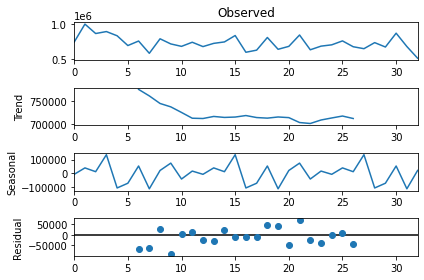

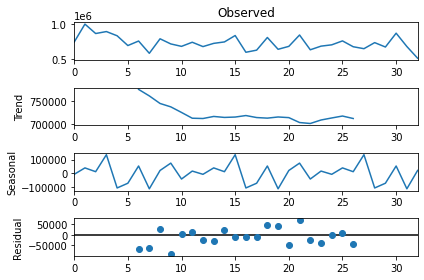

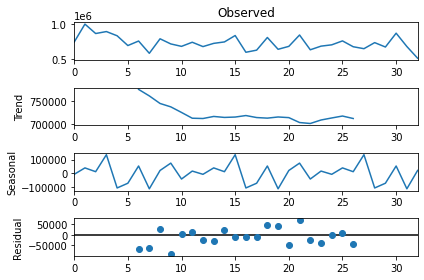

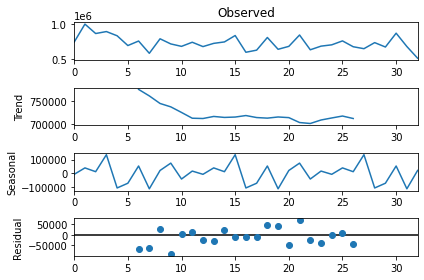

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

store_0 = time_series(resampling_data, 0)

stl = seasonal_decompose(store_0.values, freq=12)
stl.plot()

In [36]:
stlm = """
    function(ts){
        library(forecast)
        model = stlm(ts, s.window="periodic", method='ets')
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

ets = """
    function(ts){
        library(forecast)11
        model = ets(ts)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

stlm = robjects.r(stlm)
ets = robjects.r(ets)
ts = robjects.r('ts')
c = robjects.r('c')

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    data_len = len(store)
    
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
    
    if data_len > 24:
        forecast = stlm(train)
    else:
        forecast = ets(train)
        
    final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [01:37<00:00, 20.15it/s]


In [37]:
submission['amount'] = final_pred
submission.head()

,store_id,amount
0,0,2.095373e+06
1,1,3.226420e+05
2,2,1.193749e+06
3,4,2.771702e+06
4,5,9.361760e+05


,store_id,amount
0,0,2.095373e+06
1,1,3.226420e+05
2,2,1.193749e+06
3,4,2.771702e+06
4,5,9.361760e+05


## 성능향상

### 로그 정규화

In [38]:
auto_arima = """
    function(ts){
        library(forecast)
        d_params = ndiffs(ts)
        model = auto.arima(ts, max.p=2, d=d_params)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')
c = robjects.r('c')
log = robjects.r('log')
exp = robjects.r('exp')

store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4])
start_month = int(min(store_0['year_month'])[5:])

train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]

train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12)
train = ts(train['amount'], start=c(start_year, start_month), frequency=12)

forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

pred_log = np.sum(pandas2ri.ri2py(exp(forecast_log)).values)
pred = np.sum(pandas2ri.ri2py(forecast).values)

test = np.sum(test['amount'])

print('log-regularization mae: ', abs(test-pred_log))
print('mae: ', abs(test-pred))

log-regularization mae:  2537.570964200422
mae:  6009.66892536683
log-regularization mae:  2537.570964200422
mae:  6009.66892536683


In [39]:
def coefficient_variation(df, i):
    cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv = cv_data[i]
    return cv

In [40]:
ets = """
    function(ts){
        library(forecast)
        model = ets(ts)
        forecasted_data = forecast(model, h=3)
        out_df = data.frame(forecasted_data$mean)
        colnames(out_df) = c('amount')
        out_df
    }
"""

ets = robjects.r(ets)
ts = robjects.r('ts')
c = robjects.r('c')
log = robjects.r('log')
exp = robjects.r('exp')

final_pred = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    cv = coefficient_variation(resampling_data, i)
    
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year, start_month), frequency=12)
        
        forecast_log = ets(train_log)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast_log)).values))
        
    else:
        train = ts(store['amount'], start= c(start_year, start_month), frequency=12)
        
        forecast = ets(train)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [13:07<00:00,  2.50it/s]



## 모델 앙상블

In [41]:
hybridModel = """
    function(ts){
        library(forecast)
        library(forecastHybrid)
        d_params = ndiffs(ts)
        hb_mdl = hybridModel(ts, models="aes", a.arg=list(max.p=2, d=d_params),
            weight="equal")
        forecasted_data = forecast(hb_mdl, h=3)
        outdf = data.frame(forecasted_data$mean)
        colnames(outdf) = c('amount')
        outdf
    }
"""

hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts')
c = robjects.r('c')
log = robjects.r('log')
exp = robjects.r('exp')

final_pred= []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    start_year = int(min(store['year_month'])[:4])
    start_month = int(min(store['year_month'])[5:])
    
    cv = coefficient_variation(resampling_data, i)
    
    if cv < 0.3:
        train_log = ts(log(store['amount']), start=c(start_year, start_month), frequency=12)
        forecast_log = hybridModel(train_log)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast_log)).values))
    else:
        train = ts(store['amount'], start=c(start_year, start_month), frequency=12)
        forecast = hybridModel(train)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [15:36<00:00,  2.10it/s]

